# Calculating cosine similarities for generated responses from fine-tuned LLMs

In [1]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
# Read in the data
dem_1976 = pd.read_csv('dem_1976_results.csv')
dem_2016 = pd.read_csv('dem_2016_results.csv')
rep_1976 = pd.read_csv('rep_1976_results.csv')
rep_2016 = pd.read_csv('rep_2016_results.csv')

In [ ]:
# Add column for which Model it is
dem_1976['Model'] = 'Dem_1976'
dem_2016['Model'] = 'Dem_2016'
rep_1976['Model'] = 'Rep_1976'
rep_2016['Model'] = 'Rep_2016'

In [4]:
all_responses = pd.concat([dem_1976, dem_2016, rep_1976, rep_2016])
all_responses.head()

,Question,Model_Response,Model
0,Why do you believe you are fit to be the next ...,I dont think either one of us would be sitting...,Dem_1976
1,What is your overarching vision for the country?,"Well, the first thing is I believe in America....",Dem_1976
2,What is your plan to manage inflation and ensu...,"Inflation, as we all know, is caused ultimatel...",Dem_1976
3,How will you create jobs and reduce unemployme...,I believe that this forty-one percent unemploy...,Dem_1976
4,What steps will you take to balance the federa...,I have set a target for us to balance the fede...,Dem_1976


# Vectorize model responses

In [5]:
model = SentenceTransformer('all-MiniLM-L6-v2')
all_responses['Response_Vector'] = all_responses['Model_Response'].apply(lambda x: model.encode(x))


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [6]:
all_responses.head()

,Question,Model_Response,Model,Response_Vector
0,Why do you believe you are fit to be the next ...,I dont think either one of us would be sitting...,Dem_1976,"[0.0008957718, -0.031827968, 0.05873274, -0.09..."
1,What is your overarching vision for the country?,"Well, the first thing is I believe in America....",Dem_1976,"[-0.0012484089, -0.09444313, -0.008030161, -0...."
2,What is your plan to manage inflation and ensu...,"Inflation, as we all know, is caused ultimatel...",Dem_1976,"[-0.07178328, -0.080854915, 0.031707987, 0.060..."
3,How will you create jobs and reduce unemployme...,I believe that this forty-one percent unemploy...,Dem_1976,"[0.0065609454, 0.044585858, 0.057844024, -0.00..."
4,What steps will you take to balance the federa...,I have set a target for us to balance the fede...,Dem_1976,"[-0.05956662, -0.009904627, -0.025662707, -0.0..."


# Within a model - how similar are the responses for the same question (should be very similar)

In [ ]:
# Function to calculate average cosine similarity for each group
def average_cosine_similarity_for_question(group):
    vectors = np.stack(group['Response_Vector'].to_numpy())
    pairwise_similarities = cosine_similarity(vectors)

    # Extract the upper triangle of the similarity matrix without the diagonal
    n = pairwise_similarities.shape[0]
    upper_triangle_indices = np.triu_indices(n, k=1)
    upper_triangle_values = pairwise_similarities[upper_triangle_indices]

    # Return avg similarity
    return np.mean(upper_triangle_values)

In [8]:
# Group by Model and Question, and calculate the average cosine similarity
question_similarity = all_responses.groupby(['Model', 'Question']).apply(average_cosine_similarity_for_question).reset_index()
question_similarity.rename(columns={0: 'Average_Cosine_Similarity'}, inplace=True)

# Calculate overall average cosine similarity for each model
model_similarity = question_similarity.groupby('Model')['Average_Cosine_Similarity'].mean().reset_index()
model_similarity.rename(columns={'Average_Cosine_Similarity': 'Model_Average_Cosine_Similarity'}, inplace=True)


<ipython-input-8-c83d8b2b7c20>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  question_similarity = all_responses.groupby(['Model', 'Question']).apply(average_cosine_similarity_for_question).reset_index()


In [9]:
question_similarity.head()

,Model,Question,Average_Cosine_Similarity
0,Dem_1976,How will you create jobs and reduce unemployme...,0.490794
1,Dem_1976,How will you ensure equal opportunities for ma...,0.411333
2,Dem_1976,How will you ensure that all Americans have ac...,0.570870
3,Dem_1976,How will you lead the country through challeng...,0.387937
4,Dem_1976,How will you restore trust in government and e...,0.403502


In [10]:
model_similarity.head()

,Model,Model_Average_Cosine_Similarity
0,Dem_1976,0.408672
1,Dem_2016,0.382019
2,Rep_1976,0.435317
3,Rep_2016,0.326994


In [ ]:
model_labels = {
    'Dem_1976': 'Democrat 1976',
    'Dem_2016': 'Democrat 2016',
    'Rep_1976': 'Republican 1976',
    'Rep_2016': 'Republican 2016'
}

# replace the model name with more descriptive names
model_similarity['Model_Label'] = model_similarity['Model'].replace(model_labels)

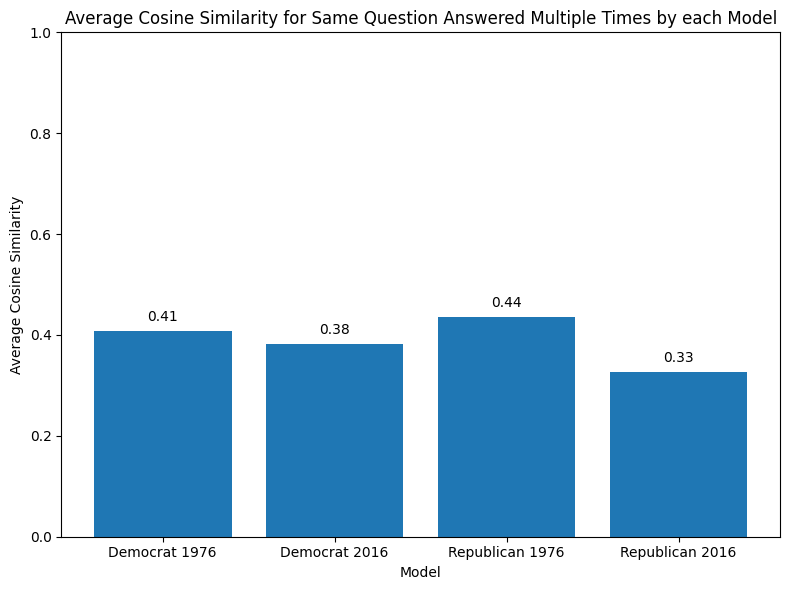

In [ ]:
plt.figure(figsize=(8, 6))
plt.bar(model_similarity['Model_Label'], model_similarity['Model_Average_Cosine_Similarity'])
plt.xlabel('Model')
plt.ylabel('Average Cosine Similarity')
plt.title('Average Cosine Similarity for Same Question Answered Multiple Times by each Model')
plt.ylim(0, 1)  

for i, value in enumerate(model_similarity['Model_Average_Cosine_Similarity']):
    plt.text(i, value + 0.02, f"{value:.2f}", ha='center')

plt.tight_layout()
plt.show();


# Between Models - how similar are the responses for the same question (should be less similar)

In [13]:
all_responses.head()

,Question,Model_Response,Model,Response_Vector
0,Why do you believe you are fit to be the next ...,I dont think either one of us would be sitting...,Dem_1976,"[0.0008957718, -0.031827968, 0.05873274, -0.09..."
1,What is your overarching vision for the country?,"Well, the first thing is I believe in America....",Dem_1976,"[-0.0012484089, -0.09444313, -0.008030161, -0...."
2,What is your plan to manage inflation and ensu...,"Inflation, as we all know, is caused ultimatel...",Dem_1976,"[-0.07178328, -0.080854915, 0.031707987, 0.060..."
3,How will you create jobs and reduce unemployme...,I believe that this forty-one percent unemploy...,Dem_1976,"[0.0065609454, 0.044585858, 0.057844024, -0.00..."
4,What steps will you take to balance the federa...,I have set a target for us to balance the fede...,Dem_1976,"[-0.05956662, -0.009904627, -0.025662707, -0.0..."


In [14]:
# group by question
grouped = all_responses.groupby('Question')

# Calculate cosine similarity between models for the same question
results = []

for question, group in grouped:
    models = group['Model'].unique()

    model_vectors = group.groupby('Model')['Response_Vector'].apply(list)

    # Compare all combinations of models
    for i in range(len(models)):
        for j in range(i + 1, len(models)):
            model_1 = models[i]
            model_2 = models[j]

            vectors_1 = np.array(model_vectors[model_1])
            vectors_2 = np.array(model_vectors[model_2])

            #  pairwise cosine similarities
            similarities = []
            for vec1 in vectors_1:
                for vec2 in vectors_2:
                    similarity = cosine_similarity([vec1], [vec2])[0, 0]
                    similarities.append(similarity)

            # Average similarity for question and pair of models
            avg_similarity = np.mean(similarities)

            # Store the result
            results.append({
                'Question': question,
                'Model_1': model_1,
                'Model_2': model_2,
                'Average_Cosine_Similarity': avg_similarity
            })

results_df = pd.DataFrame(results)
results_df.head()

,Question,Model_1,Model_2,Average_Cosine_Similarity
0,How will you create jobs and reduce unemployme...,Dem_1976,Dem_2016,0.328223
1,How will you create jobs and reduce unemployme...,Dem_1976,Rep_1976,0.445017
2,How will you create jobs and reduce unemployme...,Dem_1976,Rep_2016,0.319705
3,How will you create jobs and reduce unemployme...,Dem_2016,Rep_1976,0.318142
4,How will you create jobs and reduce unemployme...,Dem_2016,Rep_2016,0.362786


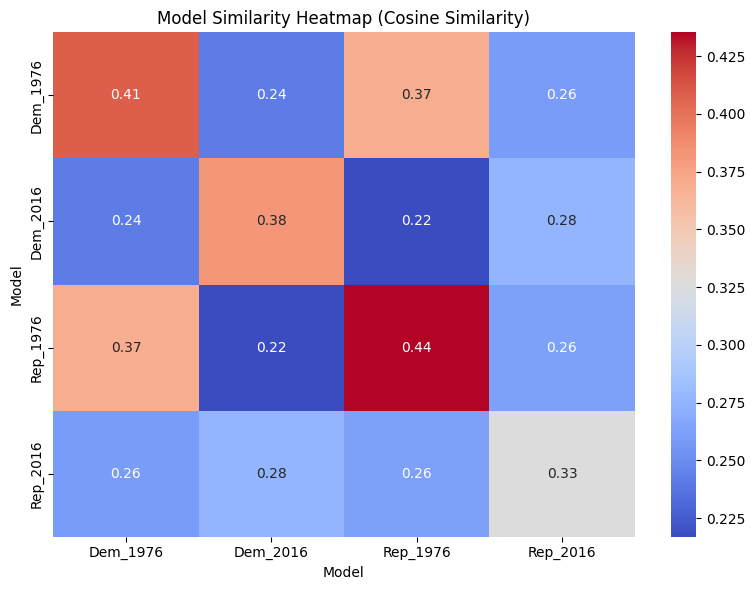

In [ ]:
# Heat map
model_similarity = pd.DataFrame({
    'Model': ['Dem_1976', 'Dem_2016', 'Rep_1976', 'Rep_2016'],
    'Model_Average_Cosine_Similarity': [0.408672, 0.382019, 0.435317, 0.326994]
})

# Create a similarity matrix
models = sorted(set(results_df['Model_1']).union(results_df['Model_2']))
similarity_matrix = pd.DataFrame(index=models, columns=models)

#Fill the matrix with average cosine similarity values
for _, row in results_df.iterrows():
    similarity_matrix.loc[row['Model_1'], row['Model_2']] = row['Average_Cosine_Similarity']
    similarity_matrix.loc[row['Model_2'], row['Model_1']] = row['Average_Cosine_Similarity']

# Use average similarity within a model
for _, row in model_similarity.iterrows():
    similarity_matrix.loc[row['Model'], row['Model']] = row['Model_Average_Cosine_Similarity']

similarity_matrix = similarity_matrix.astype(float)

plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Model Similarity Heatmap (Cosine Similarity)')
plt.xlabel('Model')
plt.ylabel('Model')
plt.tight_layout()
plt.show()


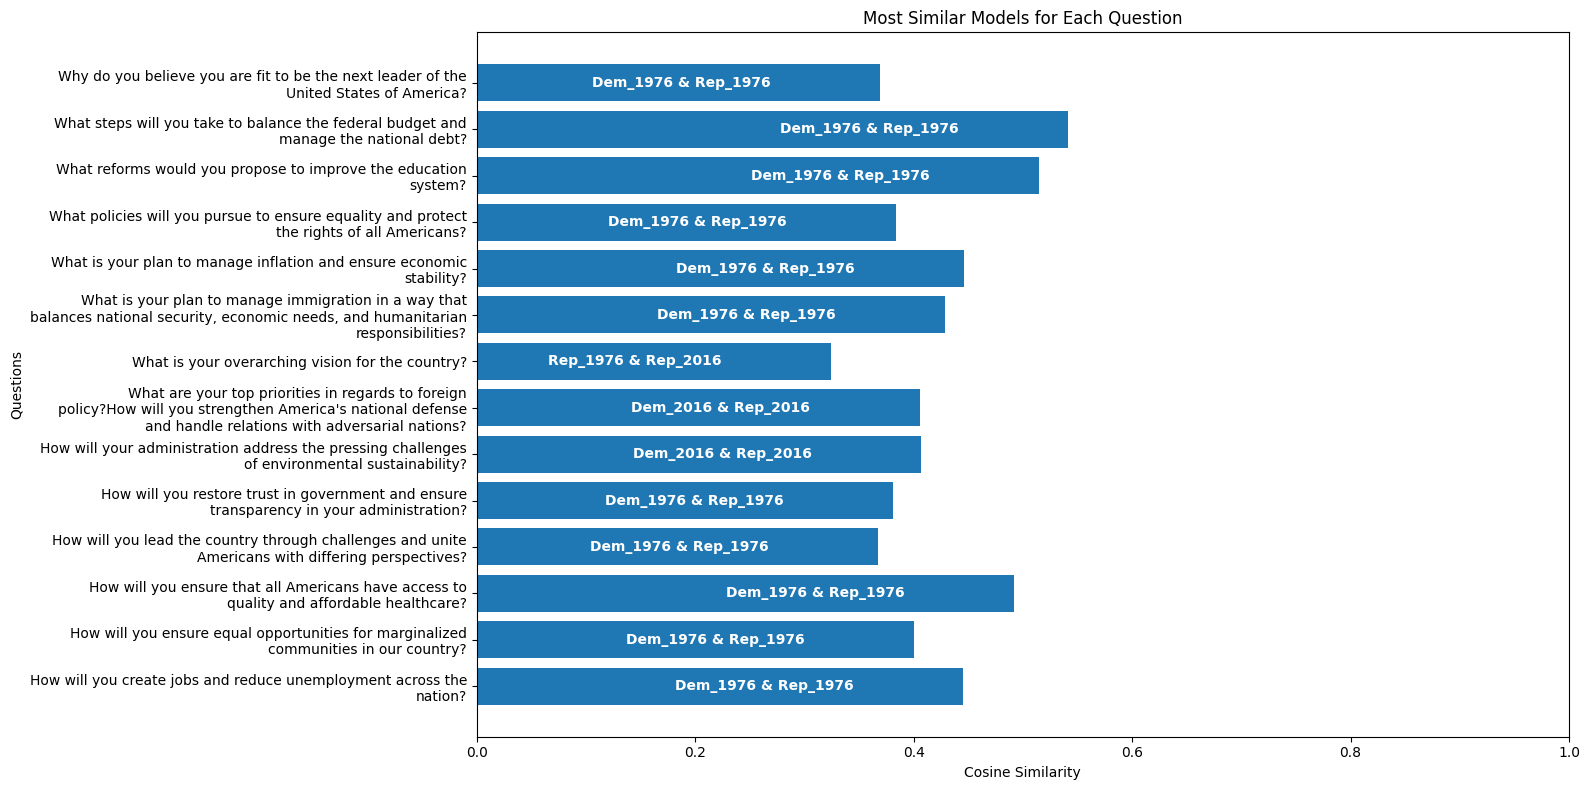

In [ ]:
# Wrap the questions for better readability
most_similar = results_df.loc[results_df.groupby('Question')['Average_Cosine_Similarity'].idxmax()]

wrapped_questions = [textwrap.fill(q, width=60) for q in most_similar['Question']]

plt.figure(figsize=(16, 8))
bars = plt.barh(wrapped_questions, most_similar['Average_Cosine_Similarity'])

# Plot
for bar, model_1, model_2, similarity in zip(bars, most_similar['Model_1'], most_similar['Model_2'], most_similar['Average_Cosine_Similarity']):
    plt.text(
        bar.get_width() - 0.1,
        bar.get_y() + bar.get_height() / 2,
        f"{model_1} & {model_2}",
        va='center', ha='right', color='white', fontsize=10, fontweight='bold'
    )
plt.xlabel('Cosine Similarity')
plt.ylabel('Questions')
plt.title('Most Similar Models for Each Question')
plt.xlim(0, 1)
plt.tight_layout()
plt.show()


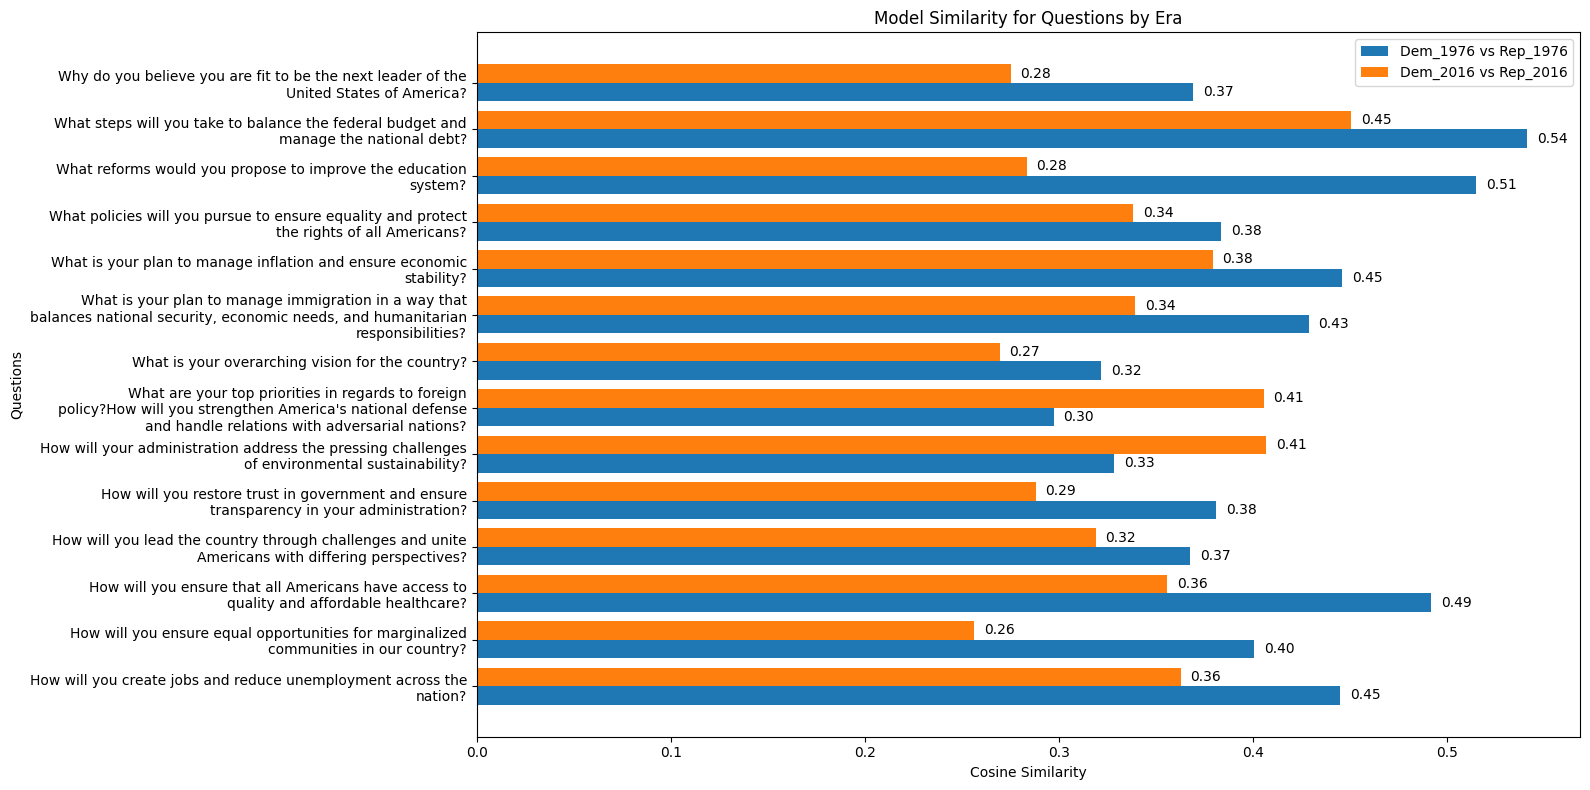

In [ ]:
# Questions plotting
# Specify model pairs
filtered_df = results_df[
    ((results_df['Model_1'] == 'Dem_1976') & (results_df['Model_2'] == 'Rep_1976')) |
    ((results_df['Model_1'] == 'Dem_2016') & (results_df['Model_2'] == 'Rep_2016'))
]

pivot_df = filtered_df.pivot(index='Question', columns='Model_1', values='Average_Cosine_Similarity')
pivot_df = pivot_df[['Dem_1976', 'Dem_2016']]  

# Text wrap questions
wrapped_questions = [textwrap.fill(q, width=60) for q in pivot_df.index]

questions = wrapped_questions
x_1976 = pivot_df['Dem_1976']
x_2016 = pivot_df['Dem_2016']

bar_width = 0.4
y_positions = np.arange(len(questions))

plt.figure(figsize=(16, 8))

plt.barh(y_positions - bar_width / 2, x_1976, bar_width, label='Dem_1976 vs Rep_1976')
plt.barh(y_positions + bar_width / 2, x_2016, bar_width, label='Dem_2016 vs Rep_2016')

plt.yticks(y_positions, questions)
plt.xlabel('Cosine Similarity')
plt.ylabel('Questions')
plt.title('Model Similarity for Questions by Era')
plt.legend()

for i, (x1, x2) in enumerate(zip(x_1976, x_2016)):
    plt.text(x1 + 0.005, y_positions[i] - bar_width / 2, f"{x1:.2f}", va='center')
    plt.text(x2 + 0.005, y_positions[i] + bar_width / 2, f"{x2:.2f}", va='center')

plt.tight_layout()
plt.show()
